In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

def data_partitioning(X_train, Y_train, num_of_clients, client_names, show_dist=True, alpha=0.2):
    # Prepare data and classes
    data = list(zip(X_train, Y_train))
    np.random.shuffle(data)
    x_tr, y_tr = zip(*data)
    y_tr = np.array(y_tr)
    if y_tr.ndim > 1:
        y_tr = np.argmax(y_tr, axis=1)
    num_of_classes = np.unique(y_tr).size

    # Class indices mapping
    classes = {f'class_{cl}': [i for i, y in enumerate(y_tr) if y == cl] for cl in range(num_of_classes)}

    # Shuffle client names
    np.random.shuffle(client_names)

    # Adjust alpha for heterogeneity
    alpha = alpha * 10
    alpha = max(alpha, 0.001)

    # Distribution matrix initialization
    dist = np.zeros((num_of_classes, num_of_clients))
    smpl_in_clss = [len(classes[class_id]) for class_id in classes]

    # Create distribution using normal distribution and softmax
    for i in range(num_of_classes):
        XX = np.random.normal(scale=alpha, size=(1, num_of_clients))
        XX_sorted = XX #np.sort(XX)
        temp_dist = np.floor(softmax(XX_sorted) * smpl_in_clss[i])
        dist[i, :] = temp_dist

    # Data distribution among clients
    Dist_Data = [[] for _ in range(num_of_clients)]
    for j in range(num_of_clients):
        for i in range(num_of_classes):
            samp_clss = int(dist[i, j])
            class_name = f'class_{i}'
            temp_samp = classes[class_name]
            for z in range(samp_clss):
                if temp_samp:
                    Dist_Data[j].append(data[temp_samp.pop()])

    # Distribution quality
    q_dist = [np.sum(dist[:, i]) for i in range(num_of_clients)]

    # Visualization of distribution
    if show_dist:
        print(f'Minimum distribution: {np.min(q_dist)}, Maximum distribution: {np.max(q_dist)}')
        x = np.linspace(1, num_of_clients, num=num_of_clients)
        plt.bar(x, q_dist)
        plt.xlabel('clients')
        plt.ylabel('number of samples')
        plt.show()

        dist = np.asarray(dist, dtype='int32')
        cm = sns.light_palette("green", as_cmap=True)
        dist_df = pd.DataFrame(dist)
        dist_df_styled = dist_df.style.background_gradient(cmap=cm, low=0.1).set_caption("Color represents sample count")
        display(dist_df_styled)

    # Prepare client data mapping
    Client_Data = {client_names[i]: Dist_Data[i] for i in range(num_of_clients)}
    return Client_Data, dist_df


### Example 

Minimum distribution: 151.0, Maximum distribution: 285.0


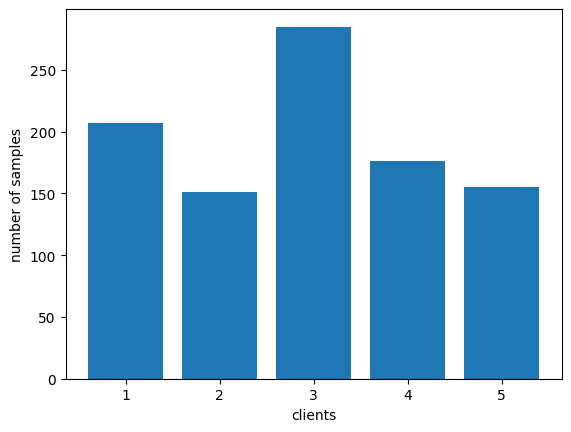

,0,1,2,3,4
0,4,2,19,47,27
1,40,11,4,6,42
2,17,1,59,4,5
3,31,11,6,45,5
4,1,39,38,9,3
5,13,35,22,14,27
6,57,23,3,6,14
7,9,6,22,32,20
8,29,19,41,4,6
9,6,4,71,9,6


In [5]:
# Example data (for demonstration)
X_train_example = np.random.rand(1000, 20)
Y_train_example = np.random.randint(0, 10, 1000)

# Define clients
client_names_example = [f'Client_{i}' for i in range(5)]

# Define heterogeneity levels (alpha values)
alpha_values_example = 0.1

# Call the function
datasets = data_partitioning(
    X_train_example,
    Y_train_example,
    num_of_clients=5,
    client_names=client_names_example,
    alpha=alpha_values_example,
    show_dist=True
)